In [ ]:
import pandas as pd

data = pd.read_csv('raw_text.csv', error_bad_lines=False);
data_text = data[['text']]
data_text['index'] = data_text.index
documents = data_text

In [2]:
len(documents)

860

In [3]:
documents[:5]

,text,index
0,The following content is\nprovided under a Cre...,0
1,"In this sequence of segments,\nwe review some ...",1
2,The following content is\nprovided under a Cre...,2
3,The following\ncontent is provided under a Cre...,3
4,The following\ncontent is provided under a Cre...,4


### Basic EDA

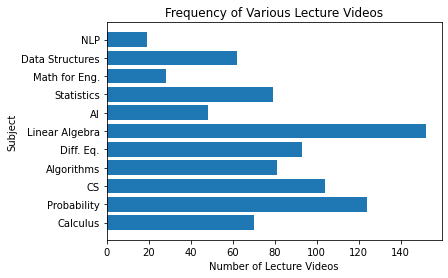

In [4]:
# Bar Plot indicating various subjects
d = {}
for sub in data.label:
  if sub not in d:
    d[sub] = 1
  else:
    d[sub] += 1

import matplotlib.pyplot as plt
plt.barh(list(d.keys()), d.values())
plt.title('Frequency of Various Lecture Videos')
plt.ylabel('Subject')
plt.xlabel('Number of Lecture Videos')
plt.show()


In [5]:
# Longest and shortest transcript
ma = -1
mi = 1000000000000
for trans in data.text:
  curr = len(trans.split())
  if curr > ma:
    ma = curr
  if curr < mi:
    mi = len(trans.split())

print('Longest Transcript has around {} number of words'.format(ma))
print('Shortest Transcript has around {} number of words'.format(mi))

Longest Transcript has around 15293 number of words
Shortest Transcript has around 111 number of words


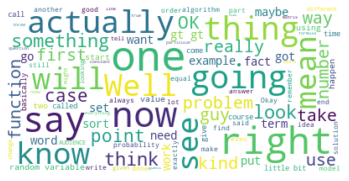

In [6]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

alltext = " ".join(trans for trans in data.text)
# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(alltext)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Multi Class Text Classification

In [15]:
import time
import matplotlib.pyplot as plt
import seaborn as sns


#word modeling
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [17]:
df = data
#Split the df for training and testing
train, test = train_test_split(df.reset_index(drop=True), test_size=.30, random_state=43)

#The Doc2Vec model takes 'tagged_documents'
#tag the training data
tagged_tr = [TaggedDocument(words=word_tokenize(_d.lower()),\
tags=[str(i)]) for i, _d in enumerate(train.d2v_text)]

#tag testing data
tagged_test = [TaggedDocument(words=word_tokenize(_d.lower()),\
tags=[str(i)]) for i, _d in enumerate(test.d2v_text)]

In [18]:
#Instantiate the model

model = Doc2Vec(vector_size=100, # 100 should be fine based on the standards
                window=8, #change to 8
                alpha=.025, #initial learning rate
                min_alpha=0.00025, #learning rate drops linearly to this
                min_count=2, #ignores all words with total frequency lower than this.
                dm =1, #algorith 1=distributed memory
                workers=16)#cores to use

#build the vocab on the training data
model.build_vocab(tagged_tr)

In [19]:
#max training epochs
max_epochs = 100

#train n epochs and save the model
t1 = time.time()
for epoch in range(max_epochs):
    print('iteration {0}'.format(epoch+1))
    model.train(tagged_tr,
                total_examples=model.corpus_count,
                epochs=model.epochs)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha
   
   

print("done!")
t2 = time.time()    
model.save("5klects1.model")
#print("Model Saved")
print("Time: {}".format(t2-t1))

iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69
iteration 70
iteration 71
iteration 72
iteration 73
iteration 74
iteration 75
iteration 76
iteration 77
iteratio

In [20]:
#Now that we have the embedding trained, we can use the infer vector method to convert the test sentences into vectors
#that can be used to model 

# Extract vectors from doc2vec model
X_train = np.array([model.docvecs[str(i)] for i in range(len(tagged_tr))])
y_train = train.label

# Extract test values
X_test = np.array([model.infer_vector(tagged_test[i][0]) for i in range(len(tagged_test))])
y_test = test.label

In [21]:
def heatconmat(y_true,y_pred):
    sns.set_context('talk')
    plt.figure(figsize=(9,6))
    sns.heatmap(confusion_matrix(y_true,y_pred),
                annot=True,
                fmt='d',
                cbar=False,
                cmap='gist_earth_r',
                yticklabels=sorted(y_test.unique()))
    plt.show()
    print(classification_report(y_true,y_pred))

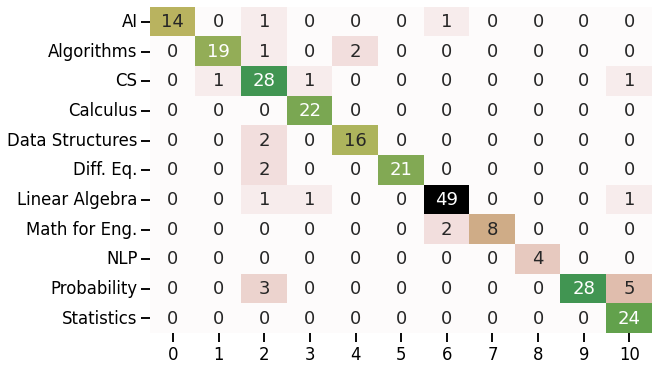

                 precision    recall  f1-score   support

             AI       1.00      0.88      0.93        16
     Algorithms       0.95      0.86      0.90        22
             CS       0.74      0.90      0.81        31
       Calculus       0.92      1.00      0.96        22
Data Structures       0.89      0.89      0.89        18
      Diff. Eq.       1.00      0.91      0.95        23
 Linear Algebra       0.94      0.94      0.94        52
  Math for Eng.       1.00      0.80      0.89        10
            NLP       1.00      1.00      1.00         4
    Probability       1.00      0.78      0.88        36
     Statistics       0.77      1.00      0.87        24

       accuracy                           0.90       258
      macro avg       0.93      0.91      0.91       258
   weighted avg       0.92      0.90      0.90       258



In [22]:
lrc = LogisticRegression(C=5, multi_class='multinomial', solver='saga',max_iter=1000)
lrc.fit(X_train,y_train)
y_pred = lrc.predict(X_test)
heatconmat(y_test,y_pred)

### Data Preprocessing

In [23]:
import gensim
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
import warnings
warnings.filterwarnings('ignore')
np.random.seed(2018)

In [24]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#### Lemmatize example

In [25]:
print(WordNetLemmatizer().lemmatize('went', pos='v'))

go


#### Stemmer Example

In [26]:
stemmer = SnowballStemmer('english')
original_words = ['caresses', 'flies', 'dies', 'mules', 'denied','died', 'agreed', 'owned', 
           'humbled', 'sized','meeting', 'stating', 'siezing', 'itemization','sensational', 
           'traditional', 'reference', 'colonizer','plotted']
singles = [stemmer.stem(plural) for plural in original_words]
pd.DataFrame(data = {'original word': original_words, 'stemmed': singles})

,original word,stemmed
0,caresses,caress
1,flies,fli
2,dies,die
3,mules,mule
4,denied,deni
5,died,die
6,agreed,agre
7,owned,own
8,humbled,humbl
9,sized,size


In [27]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [28]:
doc_sample = documents[documents['index'] == 840].values[0][0]

print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
['', '', 'Hi.', 'Today,', "we're", 'going', 'to', 'do', 'a\nreally', 'fun', 'problem', 'called', 'geniuses', 'and', 'chocolates.', 'And', 'what', 'this', 'problem', 'is\nexercising', 'is', 'your', 'knowledge', 'of', 'properties', 'of', 'probability\nlaws.', 'So', 'let', 'me', 'just', 'clarify\nwhat', 'I', 'mean', 'by', 'that.', 'Hopefully,', 'by', 'this', 'point,', 'you\nhave', 'already', 'learned', 'what', 'the', 'axioms', 'of', 'probability', 'are.', 'And', 'properties', 'of', 'probability\nlaws', 'are', 'essentially', 'any', 'rules', 'that', 'you', 'can', 'derive\nfrom', 'those', 'axioms.', 'So', 'take', 'for', 'example', 'the', 'fact\nthat', 'the', 'probability', 'of', 'A', 'union', 'B', 'is', 'equal', 'to', 'the\nprobability', 'of', 'A', 'plus', 'the', 'probability', 'of', 'B', 'minus', 'the\nprobability', 'of', 'the', 'intersection.', "That's", 'an', 'example', 'of', 'a', 'property\nof', 'a', 'probability', 'law.', 'So', 'enough', 'with', 'the', 'preamble.', "

In [29]:
processed_docs = documents['text'].map(preprocess)

In [30]:
processed_docs[:10]

0    [follow, content, provid, creativ, common, lic...
1    [sequenc, segment, review, mathemat, backgroun...
2    [follow, content, provid, creativ, common, lic...
3    [follow, content, provid, creativ, common, lic...
4    [follow, content, provid, creativ, common, lic...
5    [follow, content, provid, creativ, common, lic...
6    [follow, content, provid, creativ, common, lic...
7    [welcom, midst, figur, laplac, transform, sine...
8    [harri, today, go, decomposit, problem, proble...
9    [function, map, draw, right, draw, like, know,...
Name: text, dtype: object

----------------------------------------------------------------------

**LDA**



*   Generative Statistical Model
*   Allows a set of observations to be explained by unobserved/latent/hidden groups that explain why some parts of the data are similar
*   If observations are words collected in the form of documents
*   It posits that each document is a mixture of smaller number of topics and each word’s presence is attributable to one of the document’s topics

Each document is a **set of topics**
* Doc1 = 0.4 Politics + 0.2 Religion + 0.1 Sports
* Doc2 = 0.4 Sports + 0.1 Religion + 0.0 Politics

Each topic is a **set of words**
* Politics = 0.4 Election + 0.2 Democrat + 0.1 Republican
* Sports = 0.3 Baseball + 0.1 Football + 0.2 Basketball

</br>

**Implementation**


1.  Choose the number of topics = K
2.  Randomly assign each word in each document to one of the K topics
3.  Go through every word and its topic assignment in each document
4.  Look at :-
* How often does the topic occur in the document
* How often does the word occur in the topic

5. Reassign the word to a new topic
6. Repeat until convergence

</br>

**Example**

Assuming I have **5 documents** & I want to assign them to **8 topics**

D1 = (w1, w2, w3, w4, w5, w6, w7, w8)

D2 = (w'1, w'2, w'3, w'4, w'5, w'6, w'7, w'8, w'9, w'10)

D3 = (w“1, w“2, w“3, w“4, w“5, w“6, w“7, w“8, w“9, w“10, w“11, w“12, w“13, w“14 w“15)

D4 = (w“`1, w“`2, w“`3, w“`4, w“`5, w“`6, w“`7, w“`8, w“`9, w“`10, w“`11, w“`12)

D5 = (w““1, w““2, w““3, w““4, w““5, w““6, w““7, w““8, w““9, w““10,…, w““32, w““33, w““34)

</br>

**For the 1st Iteration**

D1 = (w1 (k5), w2 (k3), w3 (k1), w4 (k2), w5 (k5), w6 (k4), w7 (k7), w8(k1))

D2 = (w'1(k2), w'2 (k4), w'3 (k2), w'4 (k1), w'5 (k2), w'6 (k1), w'7 (k5), w'8(k3), w'9 (k7), w'10(k1))

D3 = (w“1(k3), w“2 (k1), w“3 (k5), w“4 (k3), w“5 (k4), w“6(k1),…, w“13 (k1), w“14(k3), w“15 (k2))

D4 = (w“'1(k4), w“'2 (k5), w“'3 (k3), w“'4 (k6), w“'5 (k5), w“'6 (k3) …, w“'10 (k3), w“'11 (k7), w“'12 (k1))

D5 = (w““1 (k1), w““2 (k7), w““3 (k2), w““4 (k8), w““5 (k1), w““6(k8) …, w““32(k3), w““33(k6), w““34 (k5))

</br>

The documents are the mixture of the topics:

* D1 = k5 + k3 + k1 + k2 + k5 + k4 + k7+ k1
* D2 = k2 + k4 + k2 + k1 + k5 + k2 + k1+ k5 + k3 + k7 + k1
* D3 = k4 + k5 + k3 + k6 + k5 + k3 + … + k3+ k7 + k1
* D3 = k1 + k7 + k2 + k8 + k1 + k8 + … + k3+ k6 + k5

The topics are the mixture of the words:

* K1 = w3 + w8 + w`4 + w`6 + w’10 + w“2 + w“6 + … + w“13 + w“`12 + w““1 + w““5
* K2 = w4 + w`1 + w`3 + w“15 + …. + w““3 + …
* K3 = w2 + w’8 + w“1 + w“4 + w“14 + w“`3 + w“`6 + … + w“`10 + w““32 + …

</br>

**Post the 1st iteration**

LDA will iterate over: each document ‘D’ and each word ‘w’ and needs to reassign each word to a new topic

How would it do that? It does so by computing two probabilities: p1 and p2 for every topic (k) where:

P1: proportion of words in the document (D) that are currently assigned to the topic (k)

P2: is the proportion of assignments to the topic(k) over all documents that come from this word w. In other words, p2 is the proportion of those documents in which the word (w) is also assigned to the topic (k)

Topic having the highest p1*p2 product probability will be assigned as the new topic

### Bag of words on the dataset

In [31]:
dictionary = gensim.corpora.Dictionary(processed_docs)

In [32]:
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 absolut
1 actual
2 addit
3 agenda
4 altern
5 answer
6 anti
7 appear
8 appli
9 applic
10 appropri


In [33]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

In [34]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[840]

[(13, 1),
 (17, 1),
 (24, 2),
 (40, 1),
 (48, 4),
 (65, 2),
 (86, 1),
 (104, 6),
 (105, 1),
 (109, 1),
 (117, 2),
 (123, 1),
 (131, 3),
 (140, 3),
 (147, 5),
 (153, 5),
 (164, 1),
 (228, 3),
 (237, 2),
 (290, 3),
 (292, 1),
 (295, 1),
 (309, 1),
 (318, 1),
 (324, 1),
 (333, 1),
 (348, 1),
 (358, 3),
 (361, 2),
 (371, 1),
 (373, 2),
 (403, 2),
 (420, 1),
 (452, 1),
 (474, 5),
 (491, 1),
 (496, 1),
 (507, 1),
 (531, 5),
 (553, 5),
 (591, 1),
 (602, 2),
 (660, 1),
 (671, 1),
 (702, 1),
 (713, 2),
 (714, 2),
 (719, 1),
 (732, 5),
 (735, 3),
 (736, 1),
 (747, 1),
 (754, 2),
 (766, 1),
 (787, 1),
 (799, 12),
 (805, 2),
 (828, 2),
 (836, 5),
 (842, 1),
 (849, 1),
 (850, 3),
 (911, 5),
 (912, 1),
 (914, 6),
 (950, 1),
 (979, 2),
 (1002, 6),
 (1004, 3),
 (1061, 3),
 (1172, 1),
 (1218, 3),
 (1246, 1),
 (1251, 6),
 (1262, 1),
 (1269, 4),
 (1283, 8),
 (1348, 1),
 (1509, 1),
 (1537, 2),
 (1595, 2),
 (1606, 1),
 (1720, 2),
 (1819, 3)]

In [35]:
bow_doc_840 = bow_corpus[840]

for i in range(len(bow_doc_840)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_840[i][0], 
                                                     dictionary[bow_doc_840[i][0]], 
                                                     bow_doc_840[i][1]))

Word 13 ("believ") appears 1 time.
Word 17 ("board") appears 1 time.
Word 24 ("class") appears 2 time.
Word 40 ("deriv") appears 1 time.
Word 48 ("drop") appears 4 time.
Word 65 ("express") appears 2 time.
Word 86 ("graph") appears 1 time.
Word 104 ("inform") appears 6 time.
Word 105 ("insid") appears 1 time.
Word 109 ("learn") appears 1 time.
Word 117 ("mind") appears 2 time.
Word 123 ("notic") appears 1 time.
Word 131 ("outsid") appears 3 time.
Word 140 ("plug") appears 3 time.
Word 147 ("properti") appears 5 time.
Word 153 ("random") appears 5 time.
Word 164 ("rule") appears 1 time.
Word 228 ("law") appears 3 time.
Word 237 ("set") appears 2 time.
Word 290 ("essenti") appears 3 time.
Word 292 ("exercis") appears 1 time.
Word 295 ("fair") appears 1 time.
Word 309 ("instanc") appears 1 time.
Word 318 ("lectur") appears 1 time.
Word 324 ("main") appears 1 time.
Word 333 ("notat") appears 1 time.
Word 348 ("previous") appears 1 time.
Word 358 ("refer") appears 3 time.
Word 361 ("repres"

### TF-IDF

In [36]:
from gensim import corpora, models

tfidf = models.TfidfModel(bow_corpus)

In [37]:
corpus_tfidf = tfidf[bow_corpus]

In [38]:
from pprint import pprint

for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.01716952948928818),
 (1, 0.03761389946174714),
 (2, 0.015555545527133962),
 (3, 0.0066528101876500035),
 (4, 0.003393894722871079),
 (5, 0.005910558345385177),
 (6, 0.009248135398615359),
 (7, 0.007398778823509863),
 (8, 0.009210071122420376),
 (9, 0.047745799784911835),
 (10, 0.0035434799328537326),
 (11, 0.012499362529591421),
 (12, 0.018728335321028772),
 (13, 0.0061655930063077785),
 (14, 0.054132351870443005),
 (15, 0.012078390415143338),
 (16, 0.010976494017978983),
 (17, 0.011121099168086653),
 (18, 0.011143508651617612),
 (19, 0.03714042982740488),
 (20, 0.0173450256855898),
 (21, 0.027537693544207268),
 (22, 0.01889312258036414),
 (23, 0.008810096655983958),
 (24, 0.006993913617944278),
 (25, 0.015148392752256393),
 (26, 0.044392672941059176),
 (27, 0.003996568506375464),
 (28, 0.017975592008931195),
 (29, 0.0041267144252672095),
 (30, 0.003405237733683848),
 (31, 0.008505883556350532),
 (32, 0.009403474865436785),
 (33, 0.37772422360346963),
 (34, 0.007424877022160851)

### Hyperparameter Tuning 
Only N

In [39]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        # lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)
        # model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model = gensim.models.LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)


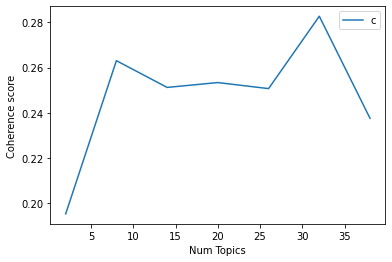

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=bow_corpus, texts=processed_docs, start=2, limit=40, step=6)
# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)


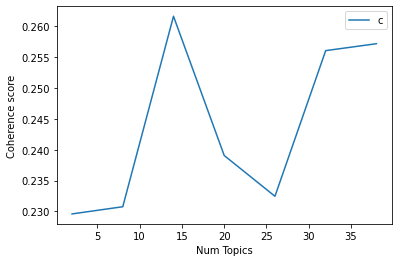

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus_tfidf, texts=processed_docs, start=2, limit=40, step=6)
# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

### Running LDA using Bag of Words

In [ ]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=30, id2word=dictionary, passes=2, workers=2)

In [ ]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.023*"list" + 0.011*"code" + 0.010*"object" + 0.009*"element" + 0.008*"class" + 0.008*"data" + 0.008*"type" + 0.007*"notic" + 0.007*"algorithm" + 0.007*"loop"
Topic: 1 
Words: 0.014*"particl" + 0.013*"vector" + 0.011*"model" + 0.009*"network" + 0.008*"input" + 0.007*"integr" + 0.007*"neural" + 0.007*"deriv" + 0.006*"layer" + 0.006*"data"
Topic: 2 
Words: 0.047*"audienc" + 0.040*"professor" + 0.015*"height" + 0.015*"tree" + 0.011*"inaud" + 0.010*"integr" + 0.008*"root" + 0.008*"node" + 0.007*"nod" + 0.006*"game"
Topic: 3 
Words: 0.019*"integr" + 0.011*"oper" + 0.011*"okay" + 0.011*"express" + 0.010*"sine" + 0.009*"distribut" + 0.009*"cosin" + 0.008*"deriv" + 0.008*"tree" + 0.007*"gamma"
Topic: 4 
Words: 0.017*"event" + 0.014*"node" + 0.014*"head" + 0.013*"tree" + 0.010*"search" + 0.009*"coin" + 0.009*"subtre" + 0.009*"condit" + 0.009*"outcom" + 0.008*"data"
Topic: 5 
Words: 0.033*"node" + 0.019*"tree" + 0.019*"data" + 0.018*"insert" + 0.015*"list" + 0.014*"array" + 0.0

Cool! Can you distinguish different topics using the words in each topic and their corresponding weights?

### Running LDA using TF-IDF

In [40]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=13, id2word=dictionary, passes=2, workers=4)

In [41]:
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.009*"node" + 0.007*"list" + 0.005*"address" + 0.005*"pointer" + 0.005*"matrix" + 0.005*"insert" + 0.005*"code" + 0.005*"loop" + 0.004*"oper" + 0.004*"data"
Topic: 1 Word: 0.007*"matrix" + 0.005*"delta" + 0.005*"integr" + 0.004*"vector" + 0.004*"transpos" + 0.004*"okay" + 0.004*"flow" + 0.003*"state" + 0.003*"stabil" + 0.003*"column"
Topic: 2 Word: 0.010*"tree" + 0.009*"node" + 0.007*"audienc" + 0.005*"theta" + 0.005*"subtre" + 0.005*"search" + 0.005*"professor" + 0.005*"algorithm" + 0.004*"integr" + 0.004*"binari"
Topic: 3 Word: 0.007*"popul" + 0.006*"laplac" + 0.005*"varianc" + 0.005*"shortest" + 0.005*"random" + 0.005*"transform" + 0.004*"integr" + 0.004*"path" + 0.004*"edg" + 0.004*"algorithm"
Topic: 4 Word: 0.006*"integr" + 0.006*"event" + 0.005*"lambda" + 0.005*"okay" + 0.004*"professor" + 0.004*"student" + 0.004*"random" + 0.004*"alpha" + 0.004*"particl" + 0.004*"distribut"
Topic: 5 Word: 0.007*"print" + 0.004*"popul" + 0.003*"gold" + 0.003*"slope" + 0.003*"objec

### Classification of the topics

### Performance evaluation by classifying sample document using LDA Bag of Words model

In [ ]:
processed_docs[840]

['today',
 'go',
 'problem',
 'call',
 'genius',
 'chocol',
 'problem',
 'exercis',
 'knowledg',
 'properti',
 'probabl',
 'law',
 'clarifi',
 'mean',
 'hope',
 'point',
 'learn',
 'axiom',
 'probabl',
 'properti',
 'probabl',
 'law',
 'essenti',
 'rule',
 'deriv',
 'axiom',
 'exampl',
 'fact',
 'probabl',
 'union',
 'equal',
 'probabl',
 'plus',
 'probabl',
 'minus',
 'probabl',
 'intersect',
 'exampl',
 'properti',
 'probabl',
 'preambl',
 'problem',
 'ask',
 'problem',
 'class',
 'student',
 'tell',
 'student',
 'genius',
 'student',
 'love',
 'chocol',
 'categori',
 'fall',
 'categori',
 'determin',
 'probabl',
 'random',
 'select',
 'student',
 'genius',
 'chocol',
 'lover',
 'want',
 'write',
 'inform',
 'give',
 'problem',
 'statement',
 'denot',
 'event',
 'random',
 'select',
 'student',
 'genius',
 'problem',
 'statement',
 'tell',
 'probabl',
 'equal',
 'similar',
 'denot',
 'event',
 'random',
 'select',
 'student',
 'chocol',
 'lover',
 'probabl',
 'equal',
 'last',
 'tell

In [ ]:
for index, score in sorted(lda_model[bow_corpus[840]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.9701414704322815	 
Topic: 0.010*"condit" + 0.009*"event" + 0.009*"program" + 0.008*"independ" + 0.007*"random" + 0.007*"model" + 0.006*"learn" + 0.006*"process" + 0.005*"lambda" + 0.005*"okay"

Score: 0.025857599452137947	 
Topic: 0.016*"expect" + 0.015*"random" + 0.007*"tree" + 0.007*"edg" + 0.006*"algorithm" + 0.006*"state" + 0.006*"model" + 0.006*"condit" + 0.006*"audienc" + 0.006*"temperatur"


Our test document has the highest probability to be part of the topic on the top.

### Performance evaluation by classifying sample document using LDA TF-IDF model

In [ ]:
for index, score in sorted(lda_model_tfidf[bow_corpus[840]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))


Score: 0.9954991936683655	 
Topic: 0.007*"matrix" + 0.006*"vector" + 0.006*"partial" + 0.005*"random" + 0.005*"integr" + 0.004*"theta" + 0.004*"expect" + 0.004*"lambda" + 0.004*"deriv" + 0.004*"transpos"


Our test document has the highest probability to be part of the topic on the top.

### Testing model on unseen document

In [ ]:
unseen_document = "".join([line.rstrip('\n') for line in open('unseen.txt')])
bow_vector = dictionary.doc2bow(preprocess(unseen_document))

sorted_scores = sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1])

for index, score in sorted_scores:
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))

ideal_topic = lda_model.print_topic(0, 5)
print('List of Tags for the Unseen Document are')
[i.split('*')[1] for i in ideal_topic.split(' + ')]

Score: 0.8260573148727417	 Topic: 0.016*"list" + 0.009*"vector" + 0.008*"code" + 0.006*"program" + 0.006*"object"
Score: 0.10366453975439072	 Topic: 0.015*"integr" + 0.012*"okay" + 0.012*"distribut" + 0.011*"deriv" + 0.008*"random"
Score: 0.06936293095350266	 Topic: 0.018*"node" + 0.014*"tree" + 0.013*"audienc" + 0.013*"professor" + 0.012*"data"
List of Tags for the Unseen Document are


['"list"', '"vector"', '"code"', '"program"', '"object"']

In [ ]:
unseen_document = "".join([line.rstrip('\n') for line in open('unseen.txt')])
bow_vector = dictionary.doc2bow(preprocess(unseen_document))

sorted_scores = sorted(lda_model_tfidf[bow_vector], key=lambda tup: -1*tup[1])

for index, score in sorted_scores:
    print("Score: {}\t Topic: {}".format(score, lda_model_tfidf.print_topic(index, 5)))

ideal_topic = lda_model.print_topic(0, 5)
print('List of Tags for the Unseen Document are')
[i.split('*')[1] for i in ideal_topic.split(' + ')]

Score: 0.700340747833252	 Topic: 0.007*"print" + 0.006*"string" + 0.004*"code" + 0.004*"program" + 0.004*"charact"
Score: 0.15523982048034668	 Topic: 0.007*"matrix" + 0.006*"vector" + 0.006*"partial" + 0.005*"random" + 0.005*"integr"
Score: 0.07425324618816376	 Topic: 0.006*"integr" + 0.006*"particl" + 0.006*"audienc" + 0.005*"professor" + 0.005*"okay"
Score: 0.05647425353527069	 Topic: 0.011*"node" + 0.007*"insert" + 0.006*"list" + 0.005*"link" + 0.005*"queue"
Score: 0.013038139790296555	 Topic: 0.025*"vector" + 0.015*"matrix" + 0.012*"column" + 0.008*"transform" + 0.007*"pivot"
List of Tags for the Unseen Document are


['"list"', '"vector"', '"code"', '"program"', '"object"']

### Evaluation

In [ ]:
# Compute Coherence Score for LDA using BOW
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3718279029107999


In [ ]:
# Compute Coherence Score for LDA using TfIdf
coherence_model_lda = CoherenceModel(model=lda_model_tfidf, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3134539600776823


### Topic Model Visualization

In [ ]:
#  !pip install pyLDAvis==3.2.1
#  !pip install pandas==1.2

     |████████████████████████████████| 1.7 MB 4.4 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.2.1-py2.py3-none-any.whl size=136187 sha256=072dfa1d0cbdd0debe568a1c399d4efd4e4ba3440ac65f2c1bd7c0d17a2e12fe
  Stored in directory: /root/.cache/pip/wheels/c6/ee/a6/7c17a63623f940dff0b9cbd7e48a27543f088fa55a7d2b62d0
Successfully built pyLDAvis
     |████████████████████████████████| 9.9 MB 4.2 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.2.0 which is incompatible.


In [ ]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)
LDAvis_prepared

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
16     0.040346  0.076747       1        1  8.499768
0     -0.065049 -0.046771       2        1  6.396215
5     -0.167974 -0.050861       3        1  6.250557
27     0.097080  0.047414       4        1  6.170748
29     0.055323  0.061908       5        1  6.056433
12     0.112773 -0.100490       6        1  5.315944
25    -0.034777  0.036070       7        1  4.281895
7      0.001221  0.054333       8        1  4.232529
14     0.080607  0.013575       9        1  4.152835
11    -0.084566 -0.011263      10        1  3.939972
19     0.104819 -0.076141      11        1  3.934625
1      0.020769 -0.014586      12        1  3.669952
10    -0.000169 -0.003560      13        1  3.453354
6     -0.004639  0.045123      14        1  3.340859
13    -0.047470  0.001589      15        1  3.307550
2     -0.043184  0.025103      16        1  3.150271
20     0.017208 -0.016239      17        1  2.821037
17    -0.026612 -0.005143      18        1  2.577483
9      0.069047 -0.006239      19        1  2.502197
15    -0.020907  0.010398      20        1  2.403214
4     -0.061717 -0.001388      21        1  2.238152
8     -0.029532  0.013818      22        1  1.629744
3      0.000832  0.017837      23        1  1.543109
24    -0.011989  0.008026      24        1  1.484604
26     0.033801 -0.061077      25        1  1.392382
28     0.044486 -0.011125      26        1  1.342703
23    -0.007795  0.018364      27        1  1.225113
22    -0.056749 -0.017206      28        1  1.085585
18    -0.027577 -0.010972      29        1  1.040258
21     0.012392  0.002756      30        1  0.560909, topic_info=         Term         Freq        Total Category  logprob  loglift
203    vector  7783.000000  7783.000000  Default  30.0000  30.0000
904    matrix  5332.000000  5332.000000  Default  29.0000  29.0000
9     audienc  6245.000000  6245.000000  Default  28.0000  28.0000
659      node  3635.000000  3635.000000  Default  27.0000  27.0000
564     state  4217.000000  4217.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
40      deriv    18.624027  3566.460401  Topic30  -5.4745  -0.0715
803   theorem    15.356526  1704.717088  Topic30  -5.6674   0.4738
1144     path    15.985343  2631.022468  Topic30  -5.6272   0.0799
153    random    16.327575  4612.636557  Topic30  -5.6061  -0.4603
19     calcul    15.423825  2148.104178  Topic30  -5.6630   0.2469

[1838 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.151653  absolut
0         2  0.041239  absolut
0         3  0.021285  absolut
0         4  0.050551  absolut
0         5  0.101102  absolut
...     ...       ...      ...
1754     19  0.015358   zeroth
1754     20  0.015358   zeroth
1754     22  0.015358   zeroth
1754     24  0.015358   zeroth
1754     27  0.015358   zeroth

[25769 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 1, 6, 28, 30, 13, 26, 8, 15, 12, 20, 2, 11, 7, 14, 3, 21, 18, 10, 16, 5, 9, 4, 25, 27, 29, 24, 23, 19, 22])

In [ ]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model_tfidf, corpus_tfidf, dictionary)
LDAvis_prepared

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.030001 -0.013679       1        1  29.099152
2      0.073916  0.011269       2        1  21.229478
5     -0.002470 -0.041134       3        1  13.155996
7     -0.041892  0.025084       4        1  12.343532
9      0.001149 -0.008855       5        1   6.149412
8     -0.032678 -0.006883       6        1   4.535586
0      0.010848  0.014315       7        1   4.437854
1     -0.011882  0.029637       8        1   3.560324
4     -0.023844 -0.023098       9        1   3.002005
3     -0.003149  0.013345      10        1   2.486661, topic_info=        Term       Freq      Total Category  logprob  loglift
203   vector  48.000000  48.000000  Default  30.0000  30.0000
889   laplac   7.000000   7.000000  Default  29.0000  29.0000
659     node  12.000000  12.000000  Default  28.0000  28.0000
695    theta  16.000000  16.000000  Default  27.0000  27.0000
828    event  10.000000  10.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
321     list   0.301374  10.700522  Topic10  -6.1655   0.1245
397     area   0.283847   8.880610  Topic10  -6.2255   0.2510
9    audienc   0.298384  17.326013  Topic10  -6.1755  -0.3674
203   vector   0.302177  48.216390  Topic10  -6.1629  -1.3782
614   column   0.289896  25.726955  Topic10  -6.2044  -0.7915

[586 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
600       1  0.212315  address
600       3  0.212315  address
600       4  0.212315  address
600       6  0.212315  address
600       7  0.212315  address
...     ...       ...      ...
878       4  0.127966   weight
878       5  0.127966   weight
385       2  0.610673    wheel
812       1  0.244330     year
812       4  0.244330     year

[859 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 3, 6, 8, 10, 9, 1, 2, 5, 4])